In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install torchsummary

In [3]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import PIL
from tqdm import tqdm
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.utils.spectral_norm as spectral_norm
import functools
import torch.nn.functional as F

In [4]:
img_size=256
n_channels=1

latent_size=100
batch_size=28
step_conv_channels=32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

beta1 = 0.0 
beta2 = 0.9

lr={
    'generator': 0.000025,
    'discriminator': 0.0001
}

num_workers=4

DATA_PATH = '...'
EPOCH_START=0
LOAD_FILENAME_PATH_GENERATOR=('....generator_epoch_%d.pth' % EPOCH_START)
LOAD_FILENAME_PATH_DISCRIMINATOR=('....discriminator_epoch_%d.pth' % EPOCH_START)

In [5]:
print(lr)

{'generator': 2.5e-05, 'discriminator': 0.0001}


In [6]:
device

device(type='cuda')

In [7]:
class Split(object):
    def __call__(self, image):
        return transforms.Grayscale(num_output_channels=n_channels)(image[1,:,:].view(n_channels,img_size,img_size))

dataset = ImageFolder(DATA_PATH, transform=transforms.Compose([
        transforms.Resize(img_size,interpolation=transforms.InterpolationMode.BICUBIC),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.Resize(upsample_transform, interpolation=transforms.InterpolationMode.BICUBIC),
        #transforms.RandomCrop((IMG_WIDTH,IMG_HEIGHT)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
        Split()
        ]))
dataloader = DataLoader(dataset, batch_size, shuffle=True,num_workers=num_workers)

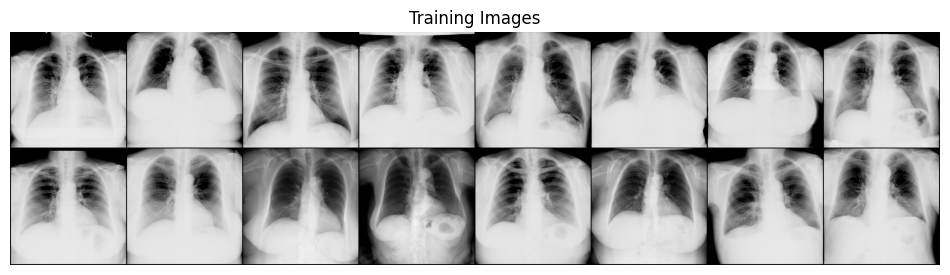

In [8]:
batch, _ = next(iter(dataloader))

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(batch[:min(16, batch_size)].to(device), padding=2, normalize=True).cpu() ,(1,2,0)))

In [9]:
class Self_Attention(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim):
        super(Self_Attention,self).__init__()
        self.chanel_in = in_dim
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size = 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size = 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim // 2 , kernel_size = 1)
        self.last_conv = nn.Conv2d(in_channels = in_dim // 2, out_channels = in_dim, kernel_size = 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
        self.pooling = nn.MaxPool2d(2,2)

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width,height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize,C//8,width*height).permute(0,2,1)
        
        proj_key =  self.key_conv(x)
        proj_key = self.pooling(proj_key).view(m_batchsize,C//8,(width*height)//4)
        
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) 
        
        proj_value = self.value_conv(x)
        proj_value = self.pooling(proj_value).view(m_batchsize,C//2,(width*height)//4)

        out = torch.bmm(proj_value,attention.permute(0,2,1))
        out = out.view(m_batchsize,C//2,width,height)
        out = self.last_conv(out)
        
        out = self.gamma*out + x
        return out

In [10]:
class GBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GBlock, self).__init__()
        self.x_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            spectral_norm(nn.Conv2d(in_channels, out_channels, 3, 1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            spectral_norm(nn.Conv2d(out_channels, out_channels, 3, 1, 1))
        )
        self.x_0_block = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            spectral_norm(nn.Conv2d(in_channels, out_channels, 3, 1, 1))
        )
    
    def forward(self, x):
        x_0 = x
        x = self.x_block(x)
        x_0 = self.x_0_block(x_0)
        return x+x_0


class SAGANGenerator(nn.Module):
    def __init__(self, encoding_dims=100, step_channels=32):
        super(SAGANGenerator, self).__init__()
        self.step_channels = step_channels

        self.linear = spectral_norm(nn.Linear(encoding_dims, step_channels * 64 * 4 * 4))

        self.model = nn.Sequential(
            GBlock(step_channels * 64, step_channels * 32),
            GBlock(step_channels * 32, step_channels * 16),
            GBlock(step_channels * 16, step_channels * 8),
            GBlock(step_channels * 8, step_channels * 4),
            Self_Attention(step_channels * 4),
            GBlock(step_channels * 4, step_channels * 2),
            GBlock(step_channels * 2, step_channels),
            nn.BatchNorm2d(step_channels),
            nn.ReLU(),
            spectral_norm(nn.Conv2d(step_channels, 1, 3, 1, 1)),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear(x).view(x.size(0),self.step_channels * 64, 4, 4)
        x = self.model(x)
        return x

In [11]:
generator=SAGANGenerator(encoding_dims=latent_size,step_channels=step_conv_channels)

summary(generator,(latent_size,1), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 32768]       3,309,568
       BatchNorm2d-2           [-1, 2048, 4, 4]           4,096
              ReLU-3           [-1, 2048, 4, 4]               0
          Upsample-4           [-1, 2048, 8, 8]               0
            Conv2d-5           [-1, 1024, 8, 8]      18,875,392
       BatchNorm2d-6           [-1, 1024, 8, 8]           2,048
              ReLU-7           [-1, 1024, 8, 8]               0
            Conv2d-8           [-1, 1024, 8, 8]       9,438,208
          Upsample-9           [-1, 2048, 8, 8]               0
           Conv2d-10           [-1, 1024, 8, 8]      18,875,392
           GBlock-11           [-1, 1024, 8, 8]               0
      BatchNorm2d-12           [-1, 1024, 8, 8]           2,048
             ReLU-13           [-1, 1024, 8, 8]               0
         Upsample-14         [-1, 1024,

In [12]:
class DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample = True):
        super(DBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.x_block = nn.Sequential(
            nn.ReLU(),
            spectral_norm(nn.Conv2d(in_channels, out_channels, 3, 1, 1)),
            nn.ReLU(),
            spectral_norm(nn.Conv2d(out_channels, out_channels, 3, 1, 1)),
        )
        self.x_0_conv = spectral_norm(nn.Conv2d(in_channels, out_channels, 1, 1))
        self.is_downsample = downsample
        self.downsample = nn.AvgPool2d(2)
        
    def forward(self, x):
        x_0 = x
        x = self.x_block(x)
        if self.is_downsample:
            x = self.downsample(x)
        if self.is_downsample or self.in_channels != self.out_channels:
            x_0 = self.x_0_conv(x_0)
            
            if self.is_downsample:
                x_0 = self.downsample(x_0)
        
        return x + x_0
    

class DBlock_optimized(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DBlock_optimized, self).__init__()
        self.x_block = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels, out_channels, 3, 1, 1)),
            nn.ReLU(),
            spectral_norm(nn.Conv2d(out_channels, out_channels, 3, 1, 1)),
        )
        self.downsample = nn.AvgPool2d(2)
        self.x_0_conv = spectral_norm(nn.Conv2d(in_channels, out_channels, 1, 1))

        
    def forward(self, x):
        x_0 = x
        x = self.x_block(x)
        x = self.downsample(x)
        x_0 = self.downsample(x_0)
        x_0 = self.x_0_conv(x_0)
        return x + x_0        
        
        
class SAGANDiscriminator(nn.Module):
    def __init__(self, step_channels=32):
        super(SAGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            DBlock_optimized(1, step_channels),
            DBlock(step_channels, step_channels * 2),
            Self_Attention(step_channels * 2),
            DBlock(step_channels * 2, step_channels * 4),
            DBlock(step_channels * 4, step_channels * 8),
            DBlock(step_channels * 8, step_channels * 16),
            DBlock(step_channels * 16, step_channels * 32),
            DBlock(step_channels * 32, step_channels * 32, downsample = False),
            nn.ReLU()
        )
     
        self.last_linear = nn.Linear(step_channels * 32, 1)
        
    def forward(self, x):
        output = self.model(x)
        output = torch.sum(output, [2,3])
        output = self.last_linear(output)
        return output

In [13]:
discriminator=SAGANDiscriminator(step_channels=step_conv_channels)
summary(discriminator,(n_channels,img_size,img_size), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
              ReLU-2         [-1, 32, 256, 256]               0
            Conv2d-3         [-1, 32, 256, 256]           9,248
         AvgPool2d-4         [-1, 32, 128, 128]               0
         AvgPool2d-5          [-1, 1, 128, 128]               0
            Conv2d-6         [-1, 32, 128, 128]              64
  DBlock_optimized-7         [-1, 32, 128, 128]               0
              ReLU-8         [-1, 32, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          18,496
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,928
        AvgPool2d-12           [-1, 64, 64, 64]               0
           Conv2d-13         [-1, 64, 128, 128]           2,112
        AvgPool2d-14           [-1, 64,

In [14]:
def fit(model, criterion, epochs, lr, epochs_start=0, uploaded=False):
    if epochs_start!=0 and not uploaded:
        model['discriminator'].load_state_dict(torch.load(LOAD_FILENAME_PATH_GENERATOR))
        model['generator'].load_state_dict(torch.load(LOAD_FILENAME_PATH_DISCRIMINATOR))
        print('Model uploaded')
        
    model["discriminator"].to(device)
    model["generator"].to(device)
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    loss_g_per_batch = []
    loss_d_per_batch = []
    real_score_per_batch = []
    fake_score_per_batch = []
    
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr['discriminator'], betas=(beta1, beta2)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr['generator'], betas=(beta1, beta2))
    }
    
    for epoch in tqdm(range(epochs)):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in dataloader:
            # discriminator step
            real_images = real_images.to(device)
            optimizer["discriminator"].zero_grad()

            # real images to discriminator
            real_preds = model["discriminator"](real_images)
            cur_real_score = torch.mean(real_preds).item()
            
            # generating images
            latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # generated images to discriminator
            fake_preds = model["discriminator"](fake_images)
            cur_fake_score = torch.mean(fake_preds).item()
                        
            real_score_per_epoch.append(cur_real_score)
            real_score_per_batch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)
            fake_score_per_batch.append(cur_fake_score)
            
            # backward pass
            loss_d = criterion['discriminator'](real_preds,fake_preds)
            loss_d.backward()
            optimizer["discriminator"].step()
            
            # logs
            loss_d_per_epoch.append(loss_d.item())
            loss_d_per_batch.append(loss_d.item())
            
            # generator step
            optimizer["generator"].zero_grad()
            
            # generating images
            latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # generated images to discriminator
            preds = model["discriminator"](fake_images)
            loss_g = criterion["generator"](preds)
            
            # backward pass
            loss_g.backward()
            optimizer["generator"].step()
            
            #logs
            loss_g_per_epoch.append(loss_g.item())
            loss_g_per_batch.append(loss_g.item())
            
        # logs
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # logs
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1+epochs_start, epochs+epochs_start, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # examples
        plt.figure(figsize=(12,12))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(np.transpose(make_grid(fake_images.to(device)[:8], padding=2, normalize=True).cpu(),(1,2,0)))
        plt.show()
        
        if (epoch+1+epochs_start)%5==0:
            torch.save(model['generator'].state_dict(),'generator_epoch_%d.pth' % (epoch+1+epochs_start))
            torch.save(model['discriminator'].state_dict(),'discriminator_epoch_%d.pth' % (epoch+1+epochs_start))
            print('Model Saved! Epoch: %d' % (epoch+1+epochs_start))
            
    
    return losses_g, loss_g_per_batch, losses_d, loss_d_per_batch, real_scores, real_score_per_batch, fake_scores, fake_score_per_batch

In [15]:
# custom weights initialization called on netG and netD
def weights_init(m):
    def _weights_init(module):
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
            nn.init.normal_(module.weight, 0.0, 0.02)
            nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.normal_(module.weight, 1.0, 0.02)
            nn.init.constant_(module.bias, 0)
    
    return m.apply(_weights_init)
    '''
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    '''

In [16]:
# hinge losses 
def generator_loss(out_fake):
    return - out_fake.mean()
    
def discriminator_loss(out_real,out_fake):
    return torch.nn.ReLU()(1.0 + out_fake).mean() + torch.nn.ReLU()(1.0 - out_real).mean()

In [17]:
generator = generator.to(device)
discriminator = discriminator.to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)

model={
    'generator' : generator,
    'discriminator' : discriminator
}

criterion={
    'generator' : generator_loss,
    'discriminator' : discriminator_loss
}


In [18]:
epochs=5

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 0.3277, loss_d: 1.9972, real_score: -0.1564, fake_score: -0.1924


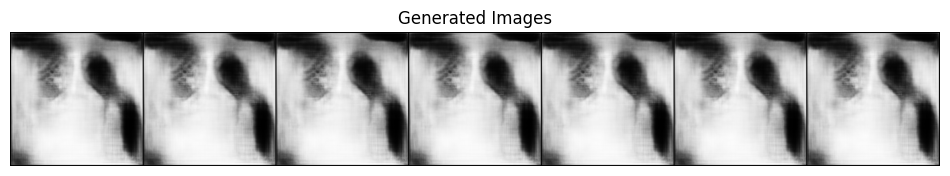

 20%|██        | 1/5 [22:19<1:29:17, 1339.46s/it]

Epoch [2/5], loss_g: 0.6912, loss_d: 1.7581, real_score: 0.0547, fake_score: -0.3983


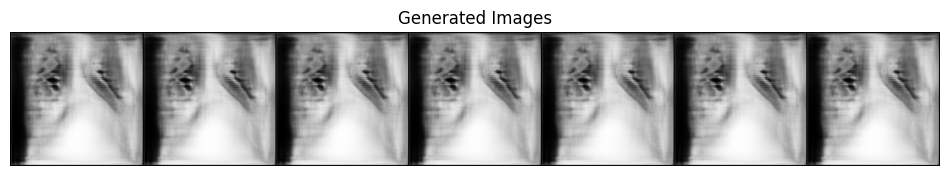

 40%|████      | 2/5 [44:38<1:06:57, 1339.09s/it]

Epoch [3/5], loss_g: 0.7376, loss_d: 1.6880, real_score: 0.3422, fake_score: -0.4251


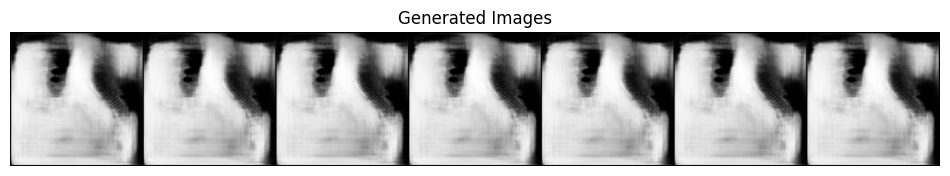

 60%|██████    | 3/5 [1:06:57<44:38, 1339.31s/it]

Epoch [4/5], loss_g: 0.9308, loss_d: 1.5583, real_score: 0.7039, fake_score: -0.5249


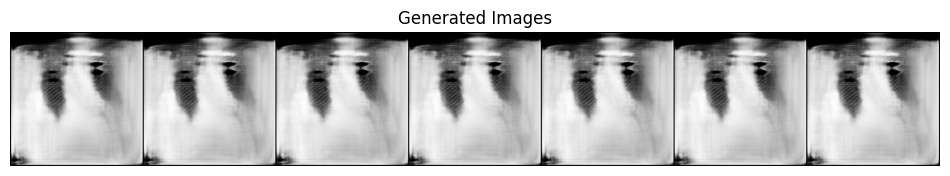

 80%|████████  | 4/5 [1:29:17<22:19, 1339.59s/it]

Epoch [5/5], loss_g: 0.8528, loss_d: 1.6158, real_score: 1.0094, fake_score: -0.4820


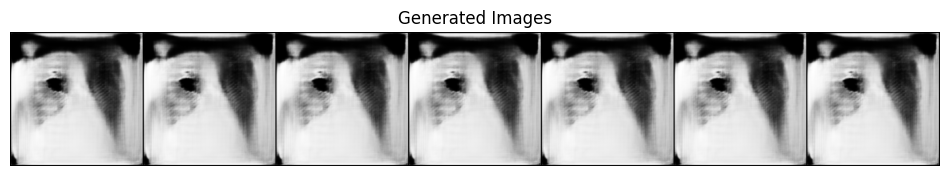

100%|██████████| 5/5 [1:51:38<00:00, 1339.70s/it]

Model Saved! Epoch: 5


In [19]:
losses_g, loss_g_per_batch, losses_d, loss_d_per_batch, real_scores, real_score_per_batch, fake_scores, fake_score_per_batch = fit(model,criterion,epochs,lr)

In [20]:
losses=[losses_g, loss_g_per_batch, losses_d, loss_d_per_batch, real_scores, real_score_per_batch, fake_scores, fake_score_per_batch]

In [21]:
txts=['losses_g','loss_g_per_batch', 'losses_d','loss_d_per_batch','real_scores','real_score_per_batch','fake_scores','fake_score_per_batch']
for i, txt in enumerate(txts):
    with open(txt+'.txt', 'w') as f:
        for e in losses[i]:
            f.write(str(e)+' ')

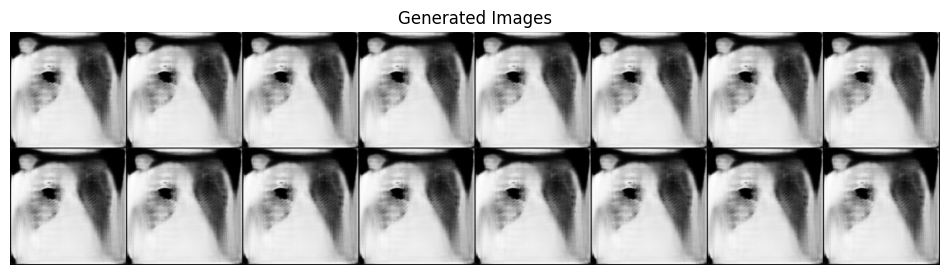

In [22]:
model['generator'].eval()
with torch.no_grad():
    z = np.array([np.random.normal(0, 1, latent_size) for i in range(16)])
    output = model['generator'](torch.FloatTensor(z).to(device))

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(make_grid(output.to(device), padding=2, normalize=True).cpu() ,(1,2,0)))